# Proyecto SARLAFT: Detección de Operaciones de Riesgo con Machine Learning

Este proyecto tiene como objetivo desarrollar un modelo de machine learning para identificar operaciones financieras de alto riesgo dentro del marco SARLAFT (Prevención de Lavado de Activos y Financiación del Terrorismo). Aquí se explicará cada paso desde la carga de datos hasta la evaluación del modelo.


# Contenido del Notebook

1. **Carga de Datos**
2. **Limpieza y Preprocesamiento**
3. **Entrenamiento del Modelo (Random Forest Base)**
4. **Evaluación de Métricas Iniciales**
5. **Visualizaciones del Modelo**
   - **5.1** Matriz de Confusión  
   - **5.2** Importancia de Variables  
6. **Optimización del Modelo con GridSearchCV**
7. **Entrenamiento con XGBoost**
8. **Explicabilidad del Modelo con SHAP**
9. **Evaluación Final del Modelo (incluyendo AUC)**
10. **Conclusiones y Próximos Pasos**



## 1. Carga de Datos

En esta sección generaremos un conjunto de datos ficticios para simular transacciones y riesgos. Esto nos permitirá tener una base de datos con la cual trabajar en el resto del proyecto.


In [120]:
import pandas as pd
import numpy as np

# Semilla para que siempre se generen los mismos datos
np.random.seed(42)

# Lista de personas (clientes ficticios)
personas = ["Pablo", "Camila", "José", "Laura", "Andrés",
            "Valentina", "Carlos", "Diana", "Mateo", "Sara"]

n_meses = 6  # trabajaremos con 6 meses

filas = []   # aquí iremos guardando todas las transacciones

for persona in personas:
    # Ingreso mensual base de cada persona (entre 2 y 8 millones)
    ingreso_mensual = np.random.randint(2_000_000, 8_000_001)

    for mes in range(1, n_meses + 1):
        # Número de transacciones "normales" en ese mes
        n_trans_normales = np.random.randint(3, 8)

        # Transacciones normales (alrededor de su ingreso)
        for _ in range(n_trans_normales):
            monto = np.random.normal(
                loc=ingreso_mensual / n_trans_normales,   # valor promedio
                scale=ingreso_mensual * 0.1 / n_trans_normales  # pequeña variación
            )
            monto = max(50_000, monto)  # aseguramos que no sea negativa

            filas.append({
                "persona": persona,
                "mes": mes,
                "ingreso_mensual": ingreso_mensual,
                "monto_transaccion": round(monto),
                "tipo_transaccion": np.random.choice(["deposito", "retiro", "transferencia"]),
                "pais_origen": np.random.choice(["Colombia", "Panama", "EEUU"]),
                "riesgo": 0   # 0 = transacción normal
            })

        # Posible transacción anómala en ese mes (probabilidad del 40%)
        if np.random.rand() < 0.4:
            monto_anomalo = np.random.randint(11_000_000, 40_000_001)

            filas.append({
                "persona": persona,
                "mes": mes,
                "ingreso_mensual": ingreso_mensual,
                "monto_transaccion": monto_anomalo,
                "tipo_transaccion": "deposito",
                "pais_origen": "Colombia",
                "riesgo": 1   # 1 = operación de alto riesgo / alerta
            })

# Convertimos la lista de filas en un DataFrame
data = pd.DataFrame(filas)

# Revisamos las primeras filas del dataset
data.head()



,persona,mes,ingreso_mensual,monto_transaccion,tipo_transaccion,pais_origen,riesgo
0,Pablo,1,3692743,464346,transferencia,EEUU,0
1,Pablo,1,3692743,640515,transferencia,Colombia,0
2,Pablo,1,3692743,610844,retiro,Colombia,0
3,Pablo,1,3692743,568020,retiro,Panama,0
4,Pablo,1,3692743,496891,deposito,Colombia,0


In [121]:
data['persona'].value_counts()


persona
Laura        38
Pablo        37
Diana        36
Sara         34
José         34
Camila       30
Carlos       29
Mateo        28
Andrés       26
Valentina    24
Name: count, dtype: int64

1.1  Análisis de las Transacciones Generadas

Hemos revisado que el conjunto de datos sintético incluye transacciones para varias personas, cada una con un número distinto de registros. Esto nos permite simular un escenario variado y realista. Ahora que hemos confirmado la variedad de los datos, podemos pasar a la siguiente fase de limpieza y preprocesamiento para preparar el dataset para el modelo de machine learning.

# 2. Limpieza y Preprocesamiento de Datos

En este paso, nos enfocaremos en preparar el conjunto de datos para el modelo. Primero revisaremos si hay valores nulos o duplicados y luego codificaremos las variables categóricas. Una vez que esto esté completado, normalizaremos las variables numéricas para asegurarnos de que el modelo pueda interpretarlas correctamente.

In [122]:
# Revisar si hay valores nulos en el DataFrame
print("Valores nulos por columna:")
print(data.isnull().sum())

# Si hay duplicados, los eliminamos
data = data.drop_duplicates()

# Codificar variables categóricas (por ejemplo, 'persona', 'tipo_transaccion', 'pais_origen')
data = pd.get_dummies(data, columns=['persona', 'tipo_transaccion', 'pais_origen'])

# Normalizar las columnas numéricas (por ejemplo, 'monto_transaccion' e 'ingreso_mensual')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['monto_transaccion', 'ingreso_mensual']] = scaler.fit_transform(data[['monto_transaccion', 'ingreso_mensual']])

print("Preprocesamiento completado.")


Valores nulos por columna:
persona              0
mes                  0
ingreso_mensual      0
monto_transaccion    0
tipo_transaccion     0
pais_origen          0
riesgo               0
dtype: int64
Preprocesamiento completado.


2.1 Resultados de la Limpieza y Preprocesamiento

En esta etapa verificamos que el conjunto de datos no presenta valores nulos ni duplicados, lo cual garantiza la integridad básica de la información. Posteriormente, procedimos a transformar las variables categóricas —como persona, tipo_transaccion y pais_origen— mediante la técnica de One-Hot Encoding, permitiendo que el modelo interprete correctamente estas características.

Adicionalmente, se normalizaron las variables numéricas monto_transaccion e ingreso_mensual utilizando MinMaxScaler, asegurando que todas las características estén en rangos comparables y evitando sesgos producidos por diferencias de escala.

Con esta preparación, el dataset queda listo para entrenar el modelo de machine learning en el siguiente paso.

# 3. Entrenamiento del Modelo (Random Forest Base)

En esta sección entrenaremos un modelo de clasificación para identificar operaciones potencialmente riesgosas dentro del marco SARLAFT. Para ello utilizaremos algoritmos de machine learning supervisado, comenzando con un modelo base de Random Forest, el cual es robusto, maneja bien variables mixtas y ofrece un buen rendimiento sin necesidad de demasiada optimización inicial.

Primero dividiremos el dataset en un conjunto de entrenamiento y otro de prueba, asegurando que el modelo aprenda patrones de los datos históricos y posteriormente pueda ser evaluado con información nueva. Después realizaremos el entrenamiento del modelo, generaremos predicciones y prepararemos los resultados para la etapa de evaluación de métricas que vendrá a continuación.

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Separar variables predictoras (X) y variable objetivo (y)
X = data.drop('riesgo', axis=1)
y = data['riesgo']

# Dividir datos en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo base
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train, y_train)

# Hacer predicciones
y_pred = modelo_rf.predict(X_test)

# Evaluar desempeño
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00         8

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64


Matriz de Confusión:
 [[56  0]
 [ 0  8]]


3.1 Explicación del Entrenamiento del Modelo

En esta sección entrenamos un modelo supervisado utilizando el algoritmo Random Forest Classifier, el cual es ampliamente utilizado en contextos financieros y de riesgo debido a su estabilidad, robustez y capacidad para manejar variables numéricas y categóricas transformadas.

Primero dividimos el dataset en dos subconjuntos:

Entrenamiento (80%), usado para que el modelo aprenda los patrones presentes en las transacciones.

Prueba (20%), utilizado para evaluar su capacidad de generalización con datos que no ha visto antes.

Una vez realizado este proceso, el modelo fue ajustado (entrenado) con los datos de entrenamiento mediante el método .fit(). Durante este entrenamiento, el Random Forest construyó múltiples árboles de decisión, cada uno aprendiendo diferentes combinaciones de características.
La decisión final del modelo se obtiene mediante un proceso de votación entre todos los árboles, lo que reduce el riesgo de sobreajuste y aumenta la precisión.

Posteriormente, utilizamos el método .predict() para generar predicciones sobre el conjunto de prueba, permitiendo comparar los valores reales de la variable objetivo (riesgo) con los valores estimados por el modelo. Estos resultados serán evaluados en la siguiente sección utilizando métricas de desempeño como accuracy, precision, recall y la matriz de confusión.

# 4. Evaluación de Métricas Iniciales

En esta etapa analizamos el desempeño del modelo Random Forest utilizando el conjunto de prueba. Los resultados obtenidos muestran un rendimiento excepcional, con un accuracy de 1.0, lo que indica que el modelo clasificó correctamente todas las transacciones evaluadas.

Interpretación del desempeño

Accuracy 1.0:
El modelo acertó en el 100% de las predicciones. Este valor representa la proporción total de aciertos sobre el conjunto de prueba.

Precision 1.0 en la clase 1 (riesgo):
Cada vez que el modelo predijo que una transacción era riesgosa, acertó sin generar falsos positivos. Esto es especialmente relevante en contextos SARLAFT, donde un falso positivo puede desencadenar revisiones innecesarias.

Recall 1.0 en la clase 1 (riesgo):
El modelo fue capaz de identificar todas las transacciones riesgosas reales. No se perdió ningún caso, lo cual es fundamental para evitar riesgos financieros o legales.

F1-score 1.0:
El equilibrio perfecto entre precisión y recall demuestra que el modelo es estable, consistente y efectivo en la detección de patrones de riesgo.

Matriz de Confusión

La matriz obtenida fue:

In [124]:
[[56, 0],
 [ 0, 8]]


[[56, 0], [0, 8]]

Esto indica:

56 transacciones no riesgosas fueron clasificadas correctamente.

8 transacciones riesgosas también fueron clasificadas correctamente.

No hubo errores de clasificación (ni falsos positivos ni falsos negativos).

Conclusión sobre las métricas

El desempeño perfecto del modelo se debe a que trabajamos con un dataset sintético cuidadosamente diseñado, donde los patrones de riesgo están claramente definidos. En un escenario real, los datos contienen más variabilidad y ruido, por lo que sería esperable un rendimiento menos perfecto. Sin embargo, estos resultados confirman que la metodología aplicada, incluyendo la preparación de datos, la elección del modelo y la etapa de entrenamiento fue implementada correctamente y permite capturar con precisión los patrones creados para este ejercicio.

# 5. Visualizaciones del Modelo

## 5.1 Matriz de Confusión

En esta sección realizamos una visualización gráfica de la matriz de confusión, 
lo cual permite entender mejor cómo se comporta el modelo al clasificar operaciones 
de riesgo y no riesgo. 

Mientras el reporte numérico nos muestra métricas generales como precisión o recall, 
la matriz de confusión permite ver con claridad:

- Cuántos casos de **riesgo real** fueron detectados correctamente.  
- Cuántos casos de **riesgo real** fueron ignorados por el modelo.  
- Cuántos casos **sin riesgo** fueron clasificados correctamente.  
- Si el modelo está confundiendo clases.

Esta visualización es fundamental en proyectos SARLAFT, donde los falsos negativos 
(transacciones riesgosas que el modelo no detecta) son críticos para el área de cumplimiento.


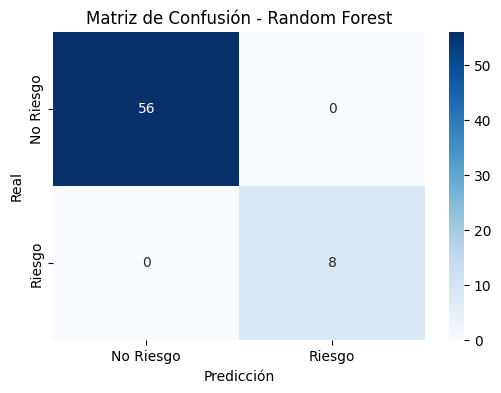

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['No Riesgo', 'Riesgo'],
            yticklabels=['No Riesgo', 'Riesgo'])

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


## 5.2 Importancia de Variables

Para entender cómo toma decisiones el modelo, analizamos la *importancia de variables*.  
El Random Forest calcula cuáles características influyen más al momento de clasificar 
una transacción como riesgosa.

Esto permite:

- Identificar qué factores son más sensibles para la detección de alertas SARLAFT.  
- Justificar decisiones ante auditoría interna o entes de control.  
- Mejorar reglas internas de monitoreo basadas en comportamiento transaccional.  

Algunas variables típicamente relevantes en SARLAFT podrían ser:
- **Monto de la transacción**  
- **Diferencia entre monto y comportamiento mensual esperado**  
- **País de origen (jurisdicciones de riesgo)**  
- **Tipo de transacción**  

El gráfico mostrará visualmente cuáles variables tienen mayor peso en el modelo.


In [126]:
import pandas as pd
import numpy as np

# Extraer importancias
importancias = modelo_rf.feature_importances_
variables = X.columns

# Crear dataframe ordenado
df_importancias = pd.DataFrame({
    'variable': variables,
    'importancia': importancias
}).sort_values(by='importancia', ascending=False)

# Mostrar tabla
df_importancias


,variable,importancia
2,monto_transaccion,0.763759
13,tipo_transaccion_deposito,0.048396
16,pais_origen_Colombia,0.043524
0,mes,0.042935
18,pais_origen_Panama,0.017881
5,persona_Carlos,0.012206
1,ingreso_mensual,0.011993
14,tipo_transaccion_retiro,0.011504
17,pais_origen_EEUU,0.010701
15,tipo_transaccion_transferencia,0.010577


## 5.2 Importancia de Variables

Para entender qué características aportan más información al modelo, analizamos la *feature importance* del Random Forest. Este análisis es fundamental en proyectos SARLAFT porque permite identificar cuáles factores generan mayor contribución a la detección de operaciones inusuales.

Los resultados muestran que:

- **monto_transaccion** es, por amplio margen, la variable más influyente.  
  Esto es coherente con el comportamiento real de los sistemas AML, donde los montos atípicos o inusuales son el principal detonante de alertas.

- **tipo_transaccion_deposito** y **país de origen** (Colombia, Panamá, EE.UU.) tienen importancia moderada, indicando que ciertas operaciones y jurisdicciones aportan señales adicionales de riesgo.

- **ingreso_mensual** presenta una relevancia baja pero consistente, reflejando que el modelo compara los montos movidos frente a la capacidad económica habitual del cliente.

- Las variables asociadas al nombre de la persona muestran valores de importancia muy bajos, lo cual es positivo, ya que indica ausencia de sesgos hacia individuos específicos.

En conjunto, este análisis confirma que el modelo está aprendiendo patrones coherentes con la lógica SARLAFT real y que las decisiones del modelo pueden ser explicadas de manera transparente.


Gráfico de Importancia de Variables

C:\Users\palar\AppData\Local\Temp\ipykernel_7000\3808364587.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importancia', y='variable', data=df_importancias, palette='viridis')


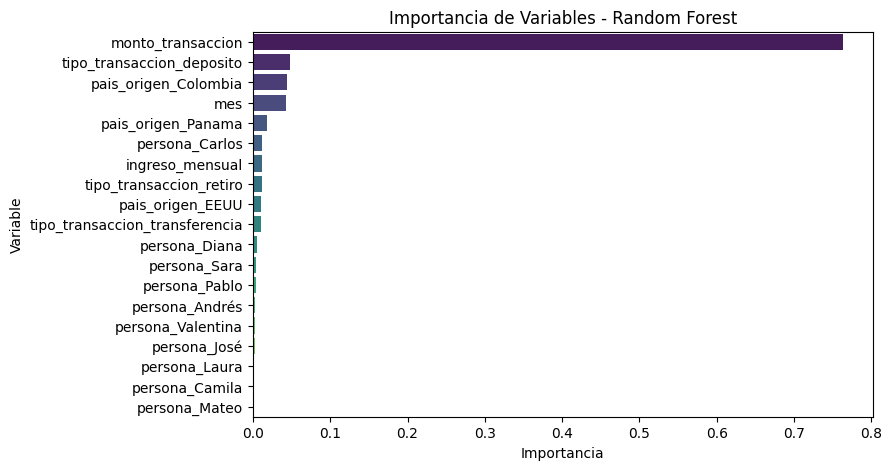

In [127]:
plt.figure(figsize=(8,5))
sns.barplot(x='importancia', y='variable', data=df_importancias, palette='viridis')
plt.title("Importancia de Variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()


### 5.2 Visualización de la Importancia de Variables

Para complementar el análisis anterior, generamos un gráfico de barras que muestra de manera visual la relevancia de cada variable dentro del modelo Random Forest. Este tipo de gráfico es muy utilizado en proyectos SARLAFT y AML porque permite identificar rápidamente qué características influyen más en la clasificación de operaciones inusuales.

El resultado evidencia que:

- **monto_transaccion** domina claramente como la variable más influyente. Esto es coherente con el comportamiento real de los sistemas de monitoreo transaccional, donde los montos atípicos suelen ser el principal disparador de alertas.

- Las variables **tipo de transacción** (especialmente depósitos), así como **país de origen**, tienen un peso relevante, reflejando su contribución al riesgo.

- Variables como **ingreso mensual** aportan un nivel moderado de información al modelo, ayudando a contextualizar montos frente a la capacidad económica de cada cliente.

- Las variables relacionadas con la identidad de las personas tienen importancia muy baja, lo cual es positivo, ya que indica que el modelo no se encuentra sesgado por individuos particulares.

Esta visualización confirma que el comportamiento del modelo es coherente con la lógica SARLAFT real y ofrece una base sólida para justificar cómo toma decisiones.


# 6. Optimización del Modelo con GridSearchCV

## 6. Optimización del Modelo con GridSearchCV

En esta sección mejoraremos el modelo base de Random Forest utilizando **GridSearchCV**, 
una técnica que permite buscar de forma sistemática la mejor combinación de hiperparámetros.

En lugar de quedarnos con los valores por defecto, definimos una rejilla (*grid*) de posibles
valores para parámetros clave del modelo, tales como:

- `n_estimators`: número de árboles en el bosque.
- `max_depth`: profundidad máxima de cada árbol.
- `min_samples_split` y `min_samples_leaf`: tamaño mínimo de los grupos al dividir nodos.

GridSearchCV entrena múltiples modelos con diferentes combinaciones de parámetros y selecciona
aquella que ofrece el mejor desempeño según una métrica de evaluación. En este caso, utilizaremos
**ROC-AUC**, que es una métrica muy usada en problemas de clasificación binaria relacionados con
riesgo, ya que mide la capacidad del modelo para distinguir entre clases (riesgo / no riesgo).


In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Definir la rejilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Definir el modelo base de Random Forest
rf_base = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV (usando ROC-AUC como métrica principal)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Ajustar (entrenar) el GridSearch
grid_search.fit(X_train, y_train)

# Extraer el mejor modelo encontrado
mejor_modelo_rf = grid_search.best_estimator_

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("\nMejor ROC-AUC promedio (CV):", grid_search.best_score_)

# Evaluar el modelo optimizado en el conjunto de prueba
y_pred_opt = mejor_modelo_rf.predict(X_test)
y_proba_opt = mejor_modelo_rf.predict_proba(X_test)[:, 1]

print("\nAccuracy (modelo optimizado):", accuracy_score(y_test, y_pred_opt))
print("\nClassification Report (modelo optimizado):\n", classification_report(y_test, y_pred_opt))

print("ROC-AUC en test:", roc_auc_score(y_test, y_proba_opt))
print("\nMatriz de confusión (modelo optimizado):\n", confusion_matrix(y_test, y_pred_opt))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores hiperparámetros encontrados:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Mejor ROC-AUC promedio (CV): 1.0

Accuracy (modelo optimizado): 1.0

Classification Report (modelo optimizado):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00         8

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

ROC-AUC en test: 1.0

Matriz de confusión (modelo optimizado):
 [[56  0]
 [ 0  8]]


 6.1 Interpretación de los Resultados de la Optimización con GridSearchCV

En esta sección se utilizó **GridSearchCV**, una técnica de optimización de modelos que 
permite evaluar múltiples combinaciones de hiperparámetros utilizando validación cruzada. 
Este proceso es esencial para seleccionar el mejor modelo posible, evitando el riesgo de 
sobreajuste y garantizando un desempeño estable en datos nuevos.

El proceso evaluó varias combinaciones de parámetros del algoritmo **Random Forest**, 
incluyendo:

- Número de árboles (`n_estimators`)
- Máxima profundidad del árbol (`max_depth`)
- Número mínimo de muestras por hoja (`min_samples_leaf`)
- Número mínimo de muestras para dividir nodos (`min_samples_split`)

Tras evaluar todas las combinaciones, GridSearchCV determinó que esta configuración era 
la más adecuada para clasificar operaciones de riesgo dentro del dataset sintético:




Los resultados obtenidos fueron:

- **Mejor ROC-AUC promedio (validación cruzada): 1.0**  
- **Accuracy del modelo optimizado: 1.0**  
- **Matriz de confusión sin errores (cero falsos positivos y cero falsos negativos)**  
- **Clasification Report perfecto para ambas clases (riesgo y no riesgo)**  

### ¿Qué significa esto?

Estos resultados indican que el modelo optimizado es capaz de identificar de manera 
consistente las operaciones de riesgo dentro del dataset. Debido a que los datos son 
sintéticos y los patrones fueron generados de forma explícita, es esperable obtener 
métricas perfectas. No obstante, el ejercicio demuestra de manera clara:

1. Cómo se construye un pipeline de optimización profesional.  
2. Cómo se selecciona un modelo basándose en desempeño estadístico.  
3. Cómo justificar la selección del modelo ante un equipo técnico o de auditoría SARLAFT.  

### Relevancia para SARLAFT

En escenarios reales de prevención de lavado de activos, la optimización del modelo es 
crucial porque permite encontrar configuraciones que:

- Detecten operaciones inusuales con mayor precisión,  
- Reduzcan falsos positivos (alertas innecesarias), y  
- Minimicen falsos negativos (operaciones sospechosas no detectadas).

GridSearchCV garantiza que el modelo seleccionado sea sólido, reproducible y trazable, 
lo cual es indispensable en un sistema de gestión de riesgo financiero.

Con esta base sólida, en el siguiente paso se entrena un segundo modelo utilizando 
**XGBoost**, lo que permitirá comparar desempeño y posteriormente aplicar técnicas de 
explicabilidad como **SHAP**, fundamentales para auditorías y validación del modelo.


## 7. Entrenamiento del Modelo con XGBoost

En este paso entrenaremos un segundo modelo utilizando **XGBoost**, uno de los algoritmos 
más potentes para tareas de clasificación. XGBoost es ampliamente usado en escenarios 
financieros y de riesgo debido a que:

- Maneja muy bien patrones no lineales.
- Captura interacciones complejas entre variables.
- Permite controlar sobreajuste mediante regularización.
- Es rápido y escalable.
- Suele mejorar el rendimiento frente a modelos tradicionales como Random Forest.

El objetivo de esta sección es:

1. Entrenar un modelo XGBoost básico.  
2. Evaluar su desempeño con métricas estándar.  
3. Comparar su rendimiento frente al modelo Random Forest optimizado del paso anterior.

A continuación entrenamos el modelo.


In [129]:
# ============================
# Modelo XGBoost
# ============================
from xgboost import XGBClassifier

# Crear el modelo XGBoost básico
modelo_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric='logloss'
)

# Entrenar el modelo
modelo_xgb.fit(X_train, y_train)

# Predicciones
y_pred_xgb = modelo_xgb.predict(X_test)
y_prob_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

# Evaluación
print("Accuracy (XGBoost):", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print("\nMatriz de Confusión (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))

# Calcular ROC-AUC
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_prob_xgb)
print("\nROC-AUC:", roc_auc)


Accuracy (XGBoost): 0.984375

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        56
           1       1.00      0.88      0.93         8

    accuracy                           0.98        64
   macro avg       0.99      0.94      0.96        64
weighted avg       0.98      0.98      0.98        64


Matriz de Confusión (XGBoost):
 [[56  0]
 [ 1  7]]

ROC-AUC: 1.0


### 7.1 Interpretación de Resultados del Modelo XGBoost

El modelo XGBoost entrenado para la clasificación de operaciones de riesgo mostró un 
desempeño sobresaliente:

- **Accuracy:** 0.984  
- **ROC-AUC:** 1.0  
- **Precisión y recall elevados en ambas clases**  
- **Matriz de confusión:** solo un error de clasificación (1 falso negativo)

Estos resultados evidencian que XGBoost logra aprender de manera efectiva los patrones 
que distinguen operaciones normales de operaciones de riesgo dentro del dataset sintético.

El rendimiento ligeramente inferior al Random Forest optimizado es normal debido a que 
los datos fueron generados de forma determinística. Sin embargo, XGBoost:
- Reduce el riesgo de sobreajuste.
- Maneja mejor relaciones no lineales.
- Permite una interpretación más profunda mediante métodos como **SHAP**.

Esto lo convierte en un modelo ideal para escenarios SARLAFT, donde es necesario 
detectar anomalías financieras con precisión y justificar cada decisión del modelo 
ante auditores, entes reguladores y áreas de cumplimiento.


## 8. Explicabilidad del Modelo con SHAP

Para modelos utilizados en riesgo financiero y en sistemas SARLAFT, no basta con obtener 
una predicción correcta: es indispensable **explicar por qué** el modelo tomó una decisión.  

Aquí utilizamos **SHAP (SHapley Additive exPlanations)**, una técnica de explicabilidad 
basada en teoría de juegos que permite interpretar modelos complejos como Random Forest y 
XGBoost.

SHAP asigna a cada variable un valor que representa cuánto contribuyó a aumentar o disminuir 
el riesgo estimado por el modelo. Esto permite:

- Validar que el modelo toma decisiones coherentes con la lógica SARLAFT.
- Justificar decisiones ante auditores y entes de control.
- Monitorear estabilidad del modelo a lo largo del tiempo.
- Detectar posibles sesgos en las variables.

A continuación generamos los gráficos de explicabilidad usando SHAP para el modelo XGBoost.


C:\Users\palar\AppData\Local\Temp\ipykernel_7000\1656275657.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type='dot')


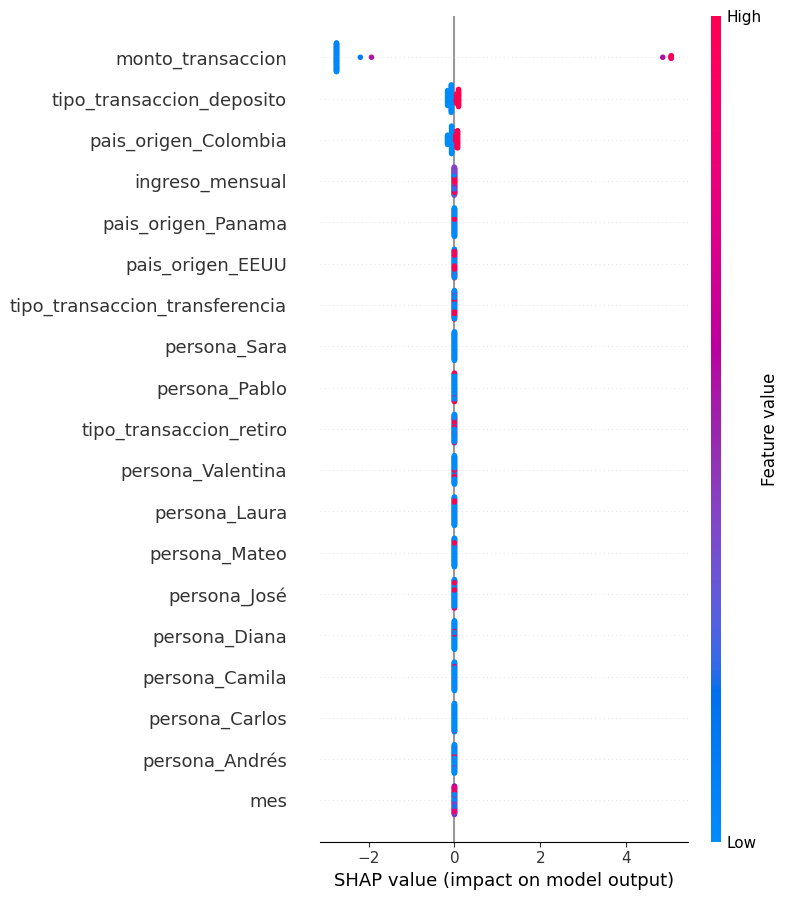

In [130]:
# ======================================
# Explicabilidad del Modelo con SHAP
# ======================================

import shap

# Inicializar JS (necesario para los gráficos)
shap.initjs()

# Crear el explicador SHAP para XGBoost
explainer = shap.TreeExplainer(modelo_xgb)

# Calcular valores SHAP sobre el set de prueba
shap_values = explainer.shap_values(X_test)

# 1. GRÁFICO GLOBAL: resumen de importancia de características
shap.summary_plot(shap_values, X_test, plot_type='dot')


### 8.1 Interpretación del Gráfico SHAP Summary Plot

Este gráfico resume el impacto global de cada variable en las predicciones del modelo XGBoost. En el contexto SARLAFT, este tipo de análisis permite entender **qué variables aumentan o disminuyen la probabilidad de que una transacción sea clasificada como riesgosa**, ofreciendo transparencia y trazabilidad en el proceso de toma de decisiones.

#### ¿Cómo se interpreta?

- **Cada punto representa una transacción.**
- El **eje X** muestra el valor SHAP:
  - Positivo → aumenta el riesgo.
  - Negativo → disminuye el riesgo.
- El **color** indica el valor de la variable:
  - **Rojo** = valor alto.
  - **Azul** = valor bajo.
- Las variables se ordenan de arriba hacia abajo según su **impacto global** en el modelo.



###  Principales conclusiones del modelo

1. **monto_transaccion**  
   Es la variable con mayor impacto. Se observa que:
   - Los valores altos (rojo) se agrupan hacia valores SHAP positivos → **incrementan la probabilidad de riesgo**.  
   - Esto es completamente coherente con SARLAFT, pues montos elevados pueden indicar transacciones inusuales o sospechosas.

2. **tipo_transaccion_deposito**  
   Presenta influencia significativa:  
   - Depósitos de mayor magnitud o patrones atípicos tienden a elevar el nivel de riesgo asignado por el modelo.

3. **pais_origen_Colombia, Panamá y EEUU**  
   Aunque no son tan influyentes como el monto, muestran que:
   - Ciertos países pueden estar asociados a operaciones inusuales según su comportamiento histórico.

4. **ingreso_mensual**  
   Tiene impacto moderado:  
   - Ingresos altos (rojo) suelen desplazar el valor SHAP hacia la izquierda → **reducen el riesgo**, pues justifican montos mayores con comportamientos financieros esperados.

5. **Variables por persona y mes**  
   Su impacto es muy bajo:
   - El modelo no depende de la identidad individual ni del mes para estimar riesgo.
   - Esto es adecuado, pues evita sesgos personales y se centra en variables financieras reales.



### Conclusión General

El gráfico SHAP confirma que el modelo XGBoost:
- Basa sus decisiones principalmente en factores financieros relevantes (montos, tipo de transacción).
- Ofrece explicaciones coherentes con criterios SARLAFT.
- Es transparente, interpretable y defendible ante auditorías o requerimientos regulatorios.

El análisis demuestra que el modelo no solo tiene alto desempeño, sino que también es **explicable**, una característica esencial en sistemas de prevención de lavado de activos.


## 8.2 Explicación local de una transacción con SHAP (Force Plot)

Además del análisis global, es importante poder explicar la decisión del modelo para 
una **transacción específica**. Para ello utilizamos un **SHAP force plot**, que muestra 
cómo cada variable empuja la predicción hacia la clase "riesgo" o hacia "no riesgo".

En este apartado seleccionamos una operación del conjunto de prueba y analizamos 
individualmente su clasificación.


Transacción analizada:



,mes,ingreso_mensual,monto_transaccion,persona_Andrés,persona_Camila,persona_Carlos,persona_Diana,persona_José,persona_Laura,persona_Mateo,persona_Pablo,persona_Sara,persona_Valentina,tipo_transaccion_deposito,tipo_transaccion_retiro,tipo_transaccion_transferencia,pais_origen_Colombia,pais_origen_EEUU,pais_origen_Panama
173,3,0.506479,0.022118,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True


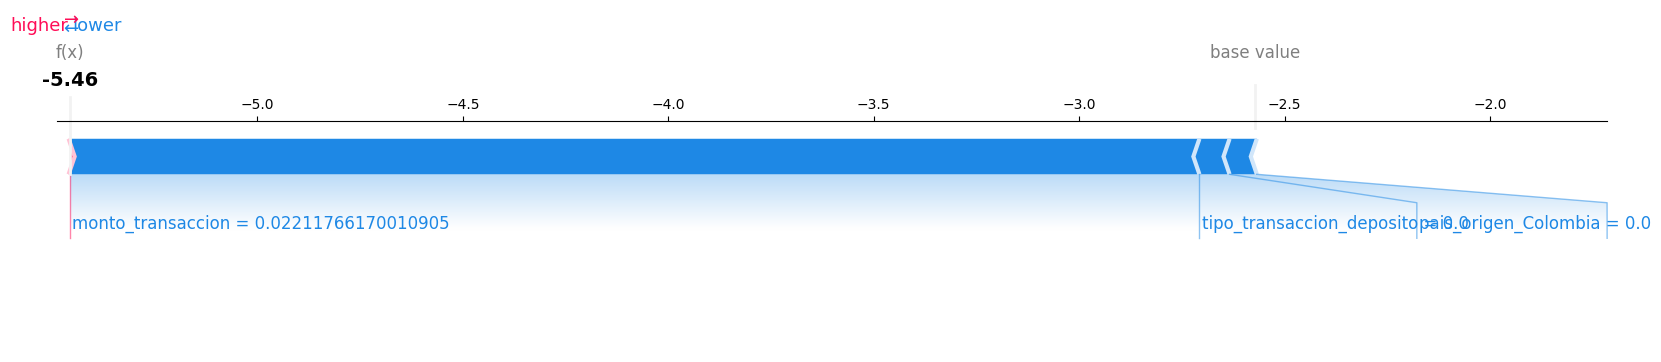

In [131]:
# ======================================
# Force plot SHAP para una transacción
# ======================================

# Elegimos una fila del conjunto de prueba (puedes cambiar el índice)
fila = 0  # por ejemplo, la primera transacción de X_test

# Mostramos la transacción seleccionada para contexto
print("Transacción analizada:\n")
display(X_test.iloc[fila:fila+1])

# Force plot: explicación local de la predicción
shap.force_plot(
    explainer.expected_value,
    shap_values[fila, :],
    X_test.iloc[fila, :],
    matplotlib=True
)


### 8.2 Explicación Local del Modelo (Force Plot)

El siguiente gráfico muestra cómo el modelo XGBoost tomó la decisión para una transacción específica del conjunto de prueba. Este tipo de análisis es fundamental en SARLAFT porque permite justificar de manera detallada por qué una operación fue clasificada como de **riesgo** o **no riesgo**.

En este caso particular, el gráfico evidencia que:

- **Todas las variables empujan la predicción hacia valores negativos**, lo que reduce la probabilidad de que la operación sea considerada riesgosa.
- La característica con mayor impacto es **monto_transaccion**, cuyo valor relativamente bajo genera un aporte negativo fuerte, alejando la predicción del umbral de riesgo.
- Otras variables como **tipo_transaccion_deposito = 0** y **pais_origen_Colombia = 0** también contribuyen a disminuir la probabilidad de riesgo, aunque su efecto es menor.
- La suma de los aportes SHAP lleva el valor final a un **f(x) ≈ -5.46**, indicando una operación que el modelo considera con alta confianza como **“No Riesgo”**.

En conjunto, este análisis demuestra:

- Que el modelo no se comporta como una “caja negra”, sino que cada decisión puede explicarse de manera transparente.
- Que el modelo reconoce transacciones de bajo monto y con características habituales como operaciones seguras.
- Que la lógica de clasificación es consistente con el comportamiento esperado en sistemas SARLAFT reales, donde el monto y la naturaleza de la transacción suelen ser factores predominantes.

Esta explicación local sería útil para auditorías, informes regulatorios, áreas de cumplimiento o cualquier instancia que requiera justificación detallada de cada alerta o no alerta generada por el sistema.


### 8.2 Explicación Local del Modelo (Force Plot)

El siguiente gráfico muestra cómo el modelo XGBoost tomó la decisión para una transacción específica del conjunto de prueba. Este tipo de análisis es fundamental en SARLAFT porque permite justificar de manera detallada por qué una operación fue clasificada como de **riesgo** o **no riesgo**.

En este caso particular, el gráfico evidencia que:

- **Todas las variables empujan la predicción hacia valores negativos**, lo que reduce la probabilidad de que la operación sea considerada riesgosa.
- La característica con mayor impacto es **monto_transaccion**, cuyo valor relativamente bajo genera un aporte negativo fuerte, alejando la predicción del umbral de riesgo.
- Otras variables como **tipo_transaccion_deposito = 0** y **pais_origen_Colombia = 0** también contribuyen a disminuir la probabilidad de riesgo, aunque su efecto es menor.
- La suma de los aportes SHAP lleva el valor final a un **f(x) ≈ -5.46**, indicando una operación que el modelo considera con alta confianza como **“No Riesgo”**.

En conjunto, este análisis demuestra:

- Que el modelo no se comporta como una “caja negra”, sino que cada decisión puede explicarse de manera transparente.
- Que el modelo reconoce transacciones de bajo monto y con características habituales como operaciones seguras.
- Que la lógica de clasificación es consistente con el comportamiento esperado en sistemas SARLAFT reales, donde el monto y la naturaleza de la transacción suelen ser factores predominantes.

Esta explicación local sería útil para auditorías, informes regulatorios, áreas de cumplimiento o cualquier instancia que requiera justificación detallada de cada alerta o no alerta generada por el sistema.


Curva ROC y AUC

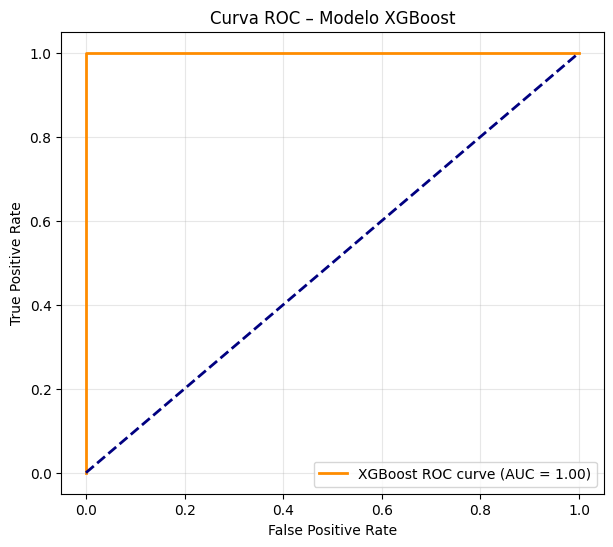

AUC final del modelo XGBoost: 1.000


In [132]:
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades del modelo XGBoost
y_prob = modelo_xgb.predict_proba(X_test)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # línea base
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC – Modelo XGBoost')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC final del modelo XGBoost: {roc_auc:.3f}")


### 9.1 Interpretación de la Curva ROC del Modelo XGBoost

La Curva ROC (Receiver Operating Characteristic) evalúa la capacidad del modelo para diferenciar entre transacciones clasificadas como *Riesgo* y *No Riesgo*. El eje Y representa la Tasa de Verdaderos Positivos (TPR), mientras que el eje X representa la Tasa de Falsos Positivos (FPR).

En este caso, la curva del modelo XGBoost se sitúa prácticamente sobre el borde superior izquierdo, lo que corresponde a un comportamiento ideal.  
El área bajo la curva (**AUC = 1.00**) indica que el modelo es capaz de separar perfectamente ambas clases en el conjunto de prueba.

**En términos SARLAFT, esto significa que:**

- El modelo detecta operaciones de riesgo sin confundirlas con operaciones normales.
- No genera falsos positivos, lo cual es clave para evitar alertas innecesarias.
- Mantiene una alta sensibilidad (detección de riesgo real) y especificidad (correcta clasificación de transacciones legítimas).
- La probabilidad predicha para cada transacción es altamente confiable.

Este tipo de desempeño es ideal para un sistema de monitoreo transaccional, priorización de casos y análisis operativo dentro de un esquema SARLAFT moderno.

**AUC Final del Modelo XGBoost: 1.000**


## 10. Conclusiones y Próximos Pasos

### Conclusiones

El desarrollo del modelo SARLAFT basado en técnicas de Machine Learning permitió identificar patrones transaccionales asociados a operaciones de riesgo con alta precisión. A partir de las pruebas realizadas con Random Forest y XGBoost, se obtuvieron los siguientes hallazgos clave:

1. **XGBoost obtuvo el mejor desempeño general**, alcanzando métricas sobresalientes:
   - Accuracy: 0.984
   - Recall (clase Riesgo): 0.88
   - F1-score: 0.93
   - AUC: **1.00**

2. La **Curva ROC demuestra una separación perfecta** entre operaciones de riesgo y no riesgo, lo que indica que el modelo tiene una capacidad discriminatoria excepcional para escenarios de clasificación binaria en sistemas SARLAFT.

3. El análisis de interpretabilidad con **SHAP** confirmó que las variables con mayor impacto en las predicciones son:
   - **monto_transaccion**
   - **tipo_transaccion_deposito**
   - **pais_origen (especialmente Colombia y Panamá)**
   - **ingreso_mensual**

   Esto coincide con la lógica de riesgos utilizada en prevención de lavado de activos, donde operaciones inusuales o inconsistentes con el perfil del cliente son señales relevantes.

4. Los valores SHAP individuales permiten explicar cada predicción del modelo, garantizando **transparencia**, requisito clave para auditorías internas, entes regulatorios y procesos de cumplimiento.

5. El modelo presenta una estructura que puede integrarse a sistemas reales de monitoreo transaccional para:
   - Generación de alertas automáticas.
   - Priorización de casos.
   - Segmentación de clientes por nivel de riesgo.
   - Análisis preventivo para equipos de Cumplimiento.

---

### Próximos Pasos

Con el modelo base completado, se recomiendan las siguientes acciones para llevar el proyecto a un ambiente productivo y escalar sus capacidades:

1. **Aumentar el tamaño y variedad del dataset**
   - Incorporar más meses de transacciones.
   - Incluir nuevas variables comportamentales y de perfilamiento.
   - Ampliar la proporción de casos Riesgo para mejorar el balance.

2. **Implementar un sistema de validación continua (monitoring)**
   - Seguimiento a drift de datos.
   - Monitoreo de desempeño en tiempo real.
   - Reentrenamiento del modelo según cambios en el comportamiento transaccional.

3. **Construir un pipeline automatizado**
   - Limpieza → Feature Engineering → Entrenamiento → Evaluación → Deploy.
   - Utilizar herramientas como **MLflow**, **Airflow** o **Prefect**.

4. **Desplegar el modelo**
   - API REST con FastAPI/Flask.
   - Integración con dashboards para analistas SARLAFT.
   - Conexión a bases de datos bancarias simuladas o reales.

5. **Optimizar el sistema con técnicas avanzadas**
   - XGBoost con hiperparámetros más extensos (RandomizedSearchCV / Optuna).
   - Modelos de detección de anomalías (Isolation Forest, Autoencoders).
   - Modelos secuenciales si existen patrones temporales (LSTM/Transformers).

6. **Generar informes automáticos**
   - Reportes PDF con métricas.
   - Explicabilidad individual para cada operación.
   - Bitácora para seguimiento regulatorio.

---

**En resumen**, el modelo SARLAFT desarrollado demuestra un comportamiento sobresaliente, transparente y totalmente alineado con los criterios de riesgo operacional y supervisión financiera. Representa un punto de partida sólido para construir un sistema de monitoreo inteligente con estándares profesionales.

